In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import tensorflow as tf

df = pd.read_csv('BTC-USD.csv')

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)


In [13]:
def convert_volume(volume_str):
    try:
        multiplier = 1
        if volume_str.endswith('K'):
            multiplier = 1000 
        elif volume_str.endswith('M'):
            multiplier = 1000000 
        elif volume_str.endswith('B'):
            multiplier = 1000000000
        return float(volume_str[:-1]) * multiplier
    except ValueError:
        return None 

df['Volume'] = df['Volume'].apply(lambda x: convert_volume(str(x)))


In [14]:
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

df = df.iloc[::-1].reset_index(drop=True)

In [15]:
df['EMA_21'] = df['Price'].ewm(span=21, adjust=False).mean()
df['EMA_12'] = df['Price'].ewm(span=12, adjust=False).mean()

df['BB_upper'] = df['Price'].rolling(window=20).mean() + 2*df['Price'].rolling(window=20).std()
df['BB_lower'] = df['Price'].rolling(window=20).mean() - 2*df['Price'].rolling(window=20).std()

def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = calculate_rsi(df['Price'])

def calculate_mfi(df, period=14):
    typical_price = (df['High'] + df['Low'] + df['Price']) / 3
    money_flow = typical_price * df['Volume']
    positive_flow = (money_flow.where(typical_price.diff(1) > 0, 0)).rolling(window=period).sum()
    negative_flow = (money_flow.where(typical_price.diff(1) < 0, 0)).rolling(window=period).sum()
    mfi = 100 - (100 / (1 + positive_flow / negative_flow))
    return mfi

df['MFI'] = calculate_mfi(df)

df['14-high'] = df['High'].rolling(14).max()
df['14-low'] = df['Low'].rolling(14).min()
df['Stochastic'] = (df['Price'] - df['14-low']) / (df['14-high'] - df['14-low']) * 100

df.dropna(inplace=True)

In [16]:
features = ['Price', 'Open', 'High', 'Low', 'Volume', 'Change %', 'EMA_21', 'EMA_12', 'BB_upper', 'BB_lower', 'RSI', 'MFI', 'Stochastic']
data = df[features].values

scalers = {}
for i in range(data.shape[1]):
    scalers[i] = MinMaxScaler(feature_range=(0, 1))
    data[:, i] = scalers[i].fit_transform(data[:, i].reshape(-1, 1)).reshape(-1)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 6
X, y = create_sequences(data, seq_length)

split_ratio = 0.8
train_size = int(len(X) * split_ratio)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], data.shape[1]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], data.shape[1]))


In [17]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, data.shape[1])),
    MaxPooling1D(pool_size=1),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=1),
    Dropout(0.2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
])

Epoch 1/50


d:\Python\File install\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9246e-04 - val_loss: 0.0059
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4038e-04 - val_loss: 0.0032
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9246e-04 - val_loss: 8.5344e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7592e-04 - val_loss: 0.0058
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6409e-04 - val_loss: 0.0021
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5336e-04 - val_loss: 0.0099
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2091e-04 - val_loss: 0.0050
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6907e-04 - val_loss: 0.0042
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2740e-04 - val_loss: 0.0017
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1415e-04 - val_loss: 0.0029
Epoch 12/50
100/100

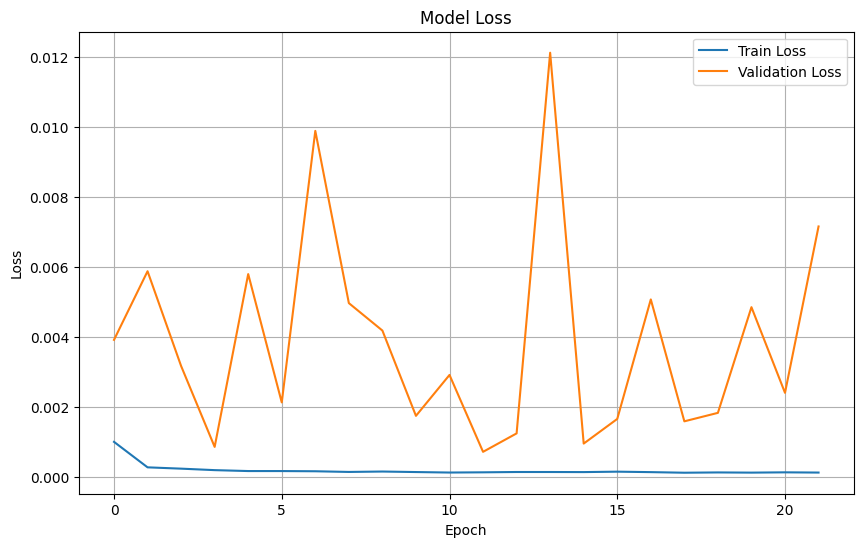

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6358e-04
Test Loss: 0.0007307738997042179


In [18]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


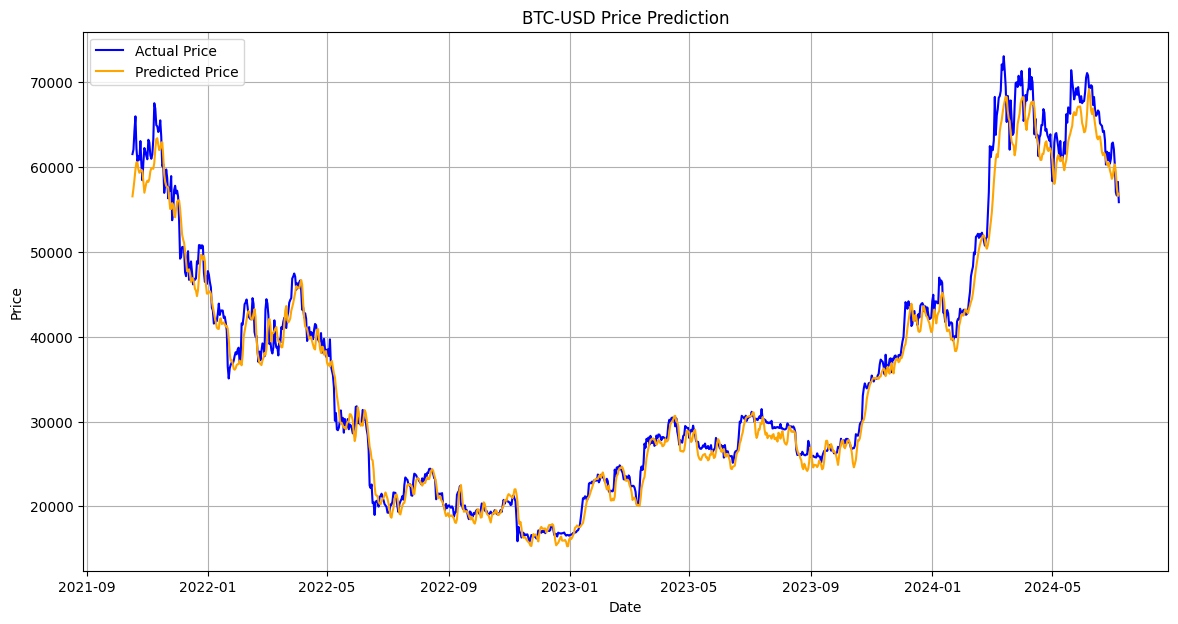

In [19]:
y_pred = model.predict(X_test)
y_pred = scalers[0].inverse_transform(y_pred)  
y_test_inverse = scalers[0].inverse_transform(y_test.reshape(-1, 1))

dates = df['Date'].iloc[-len(y_test_inverse):]

plt.figure(figsize=(14, 7))
plt.plot(dates, y_test_inverse, label='Actual Price', color='blue')
plt.plot(dates, y_pred, label='Predicted Price', color='orange')
plt.title('BTC-USD Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
last_sequence = data[-seq_length:]
last_sequence = last_sequence.reshape((1, seq_length, data.shape[1]))

predicted_price = model.predict(last_sequence)
predicted_price = scalers[0].inverse_transform(predicted_price) 

print(f"Predicted BTC-USD closing price for the next day: {predicted_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted BTC-USD closing price for the next day: 56712.52734375


In [21]:
actual_prices = pd.Series(y_test_inverse.flatten(), name='Actual Price')
predicted_prices = pd.Series(y_pred.flatten(), name='Predicted Price')

comparison_df = pd.DataFrame({'Actual Price': actual_prices, 'Predicted Price': predicted_prices})
comparison_df['Price Difference'] = comparison_df['Actual Price'] - comparison_df['Predicted Price']

print(comparison_df.head())

   Actual Price  Predicted Price  Price Difference
0       61527.5     56545.718750       4981.781250
1       62056.3     57466.734375       4589.565625
2       64278.5     58518.316406       5760.183594
3       65979.1     59719.113281       6259.986719
4       62210.2     60566.296875       1643.903125


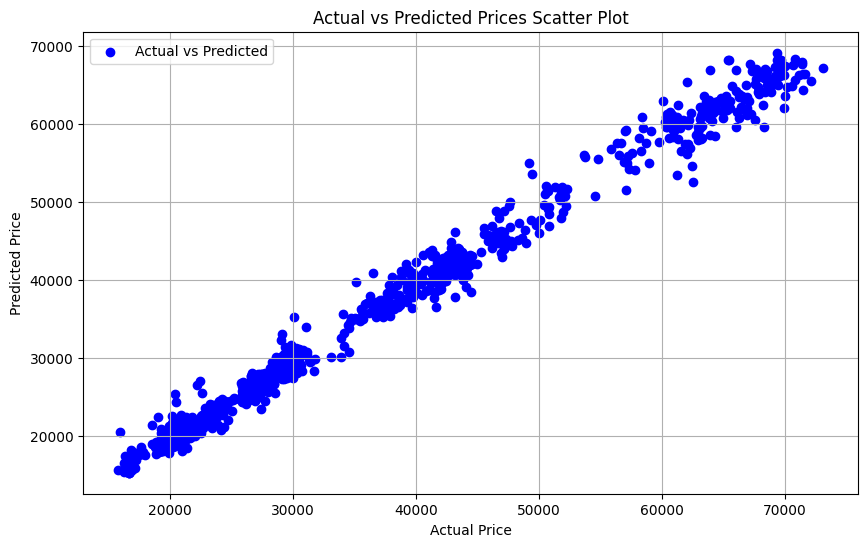

In [22]:

plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['Actual Price'], comparison_df['Predicted Price'], color='blue', label='Actual vs Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices Scatter Plot')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)
y_pred = scalers[0].inverse_transform(y_pred)
y_test_inverse = scalers[0].inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_inverse, y_pred)
mae = mean_absolute_error(y_test_inverse, y_pred)
r2 = r2_score(y_test_inverse, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Squared Error (MSE): 3901348.899615958
Mean Absolute Error (MAE): 1422.4677330009424
R-squared: 0.9844577695422538
